In [1]:
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Pour les performances de classification
from imblearn.under_sampling import RandomUnderSampler
from keras.optimizers import SGD,Adam
from datetime import datetime
maintenant = datetime.now()
print(maintenant)
import tensorflow as tf

# activation GPU

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)




from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense # Pour construire un réseau de neurones et
                                                 # instancier une couche d'entrée et une couche den
from sklearn.ensemble import RandomForestClassifier # Pour instancier et entraîner un modèle Random Forest
import matplotlib.pyplot as plt
import os
#import cv2
import gc
import itertools # Pour créer des itérateurs
import pickle

2024-07-09 08:11:20.495731
1 Physical GPUs, 1 Logical GPUs


In [2]:
VERSION = "_FINAL"
SUFFIXE_FICHIER = "VGG16" + VERSION
STRATEGIE = "sampling_strategy_B1" + VERSION +".csv" # effectifs par classe retenu après over et under sampling
IMGSIZE       = 450    # Taille de l'image en input
EPOCH         = 20     # nombre d'epoch 
BATCH_SIZE    = 32     # traitement par batch d'images avant la descente de gradient
FREEZE_LAYERS = 15     # pour un EfficientNetB1 freeze de réapprentissage de certaines couches  (19 couches au total)
NB_PAR_LABEL_MAX = 5000 # nombre maximun d'enregistrement par label = undersampling
NB_PAR_LABEL_MIN = 2000 # nombre maximun d'enregistrement par label = oversampling
TRAIN         = True   # Entrainement ou utilisation d'un réseau déjà entrainé

In [3]:
import sys
sys.path.append('../src')
import Bibli_DataScience_3_2 as ds
import CNN_DataScience_2 as cnn

section :  ['DOSSIER', 'FICHIER']


In [4]:
# Pour recharger si nesséssaire
import imp
imp.reload(ds)
imp.reload(cnn)

section :  ['DOSSIER', 'FICHIER']


<module 'CNN_DataScience_2' from 'E:\\Manuel\\PROJET\\Rakuten_Images_Classification_TensorFlow\\notebooks\\../src\\CNN_DataScience_2.py'>

In [4]:
# lecture des données sources d'entrainement
df_feats=pd.read_csv(ds.get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(ds.get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)
#cat=df_target['prdtypecode'].sort_values().unique()
nomenclature=pd.read_csv(ds.get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']
Lcat=df_target.sort_values(by = ['prdtypecode'])['prdtypecode'].unique()
Lcat

array([  10,   40,   50,   60, 1140, 1160, 1180, 1280, 1281, 1300, 1301,
       1302, 1320, 1560, 1920, 1940, 2060, 2220, 2280, 2403, 2462, 2522,
       2582, 2583, 2585, 2705, 2905], dtype=int64)

In [5]:
df['nom_image']=df.apply(lambda row: "image_" +  str(row['imageid']) 
                                     + "_product_" + str(row['productid']) + ".jpg",axis=1)
print("Nb enreg ", str(df.shape[0]))
df_img=df.copy()

Nb enreg  84916


In [6]:
folder_path = ds.get_RACINE_IMAGES() 
df['filepath']=df['nom_image'].apply(lambda x : os.path.join(folder_path, x))

## test de lecture d'image¶

Taille de l'image : (500, 500, 3)


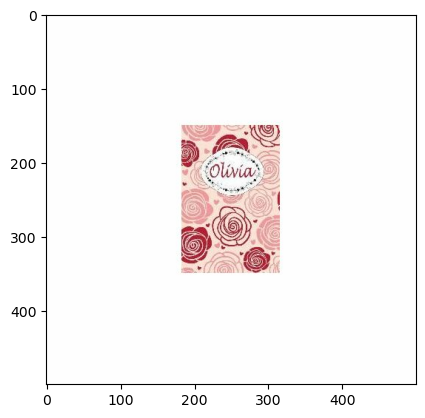

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Chemin de l'image
filename = df.nom_image[0]
filepath = os.path.join(folder_path, filename)
# Lecture du fichier
im = tf.io.read_file(filepath)

# On décode le fichier
im = tf.image.decode_jpeg(im, channels=3)

print("Taille de l'image :", im.shape)

# Affichage du tensor
plt.imshow(im);

### REDIMENSIONNEMENT
Pour avoir un temps d'entrainement du modèle raisonnable,  
il est nécessaire de redimensionner les images.  
**A l'origine les images ont une taille de 500*500 pixels.**

In [8]:
filepath = df.filepath[0]
# Lecture du fichier
im = tf.io.read_file(filepath)
# On décode le fichier
im = tf.image.decode_jpeg(im, channels=3)
# Redimensionnement
tf.image.resize(im, size=(IMGSIZE,IMGSIZE))


<tf.Tensor: shape=(450, 450, 3), dtype=float32, numpy=
array([[[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       ...,

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.],
        ...,
        [254., 254., 254.],
        [254., 254., 254.],
        [254., 254., 254.]],

       [[254., 25

In [9]:
from sklearn.model_selection import train_test_split

import numpy as np

X = df.drop('prdtypecode', axis=1)
y = df['prdtypecode'] 

X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(X, y, train_size=0.8, random_state=1234,
                                                              stratify=y,shuffle=True)

In [10]:
X_train = np.array(X_train_avant['filepath'])
print(X_train.shape)
X_test = np.array(X_test_avant['filepath'])
y_train = np.array(y_train_avant)
print(X_test.shape)
y_test = np.array(y_test_avant )
X_train=X_train.reshape(-1,1)
y_train=y_train.reshape(-1,1)
X_test=X_test.reshape(-1,1)
y_test=y_test.reshape(-1,1)

(67932,)
(16984,)


### Evaluation de la répartition des catégories

In [11]:
y_serie =pd.Series(y_train.reshape(-1,)).value_counts()
majority_class = y_serie.index[0]
print(majority_class)
y_serie

2583


2583    8167
1560    4058
1300    4036
2060    3994
2522    3991
1280    3896
2403    3819
2280    3808
1920    3442
1160    3162
1320    2593
10      2493
2705    2209
1140    2137
2582    2071
40      2006
2585    1997
1302    1993
1281    1656
50      1345
2462    1137
2905     698
60       666
2220     659
1301     646
1940     642
1180     611
Name: count, dtype: int64

### UNDERSAMPLING
On effectue un undersampling définit par le paramètre : NB_PAR_LABEL_MAX (cf debut de programme)    
Ici **undersampling à 5000**

In [12]:
new_class_counts = y_serie.copy()
sampling_strategy=new_class_counts.to_dict()
for key in sampling_strategy:
  if sampling_strategy[key] > NB_PAR_LABEL_MAX:  
    sampling_strategy[key] = NB_PAR_LABEL_MAX
del y_serie,new_class_counts
#print(type(sampling_strategy))
spstrag=pd.DataFrame.from_dict(sampling_strategy,orient='index').rename(columns={0:'Qunatity'})
spstrag.to_csv(ds.get_RACINE_SAUVEGARDE()+STRATEGIE)
print("Stategie de sampling")
sampling_strategy

Stategie de sampling


{2583: 5000,
 1560: 4058,
 1300: 4036,
 2060: 3994,
 2522: 3991,
 1280: 3896,
 2403: 3819,
 2280: 3808,
 1920: 3442,
 1160: 3162,
 1320: 2593,
 10: 2493,
 2705: 2209,
 1140: 2137,
 2582: 2071,
 40: 2006,
 2585: 1997,
 1302: 1993,
 1281: 1656,
 50: 1345,
 2462: 1137,
 2905: 698,
 60: 666,
 2220: 659,
 1301: 646,
 1940: 642,
 1180: 611}

In [13]:

rUs = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_ru, y_ru = rUs.fit_resample(X_train, y_train  )
#del   X_Reshape, y
#gc.collect()
print(len(X_ru))
print(len(X_ru))

64765
64765


##### Après la répartition entre le jeu de test et le jeu d'entrainement  
**la classe la plus représentée** du jeu d'entrainement comporte **5000 occurences**

In [14]:
y_serie =pd.Series(y_ru).value_counts()
majority_class = y_serie.index[0]
print(majority_class)
y_serie

2583


2583    5000
1560    4058
1300    4036
2060    3994
2522    3991
1280    3896
2403    3819
2280    3808
1920    3442
1160    3162
1320    2593
10      2493
2705    2209
1140    2137
2582    2071
40      2006
2585    1997
1302    1993
1281    1656
50      1345
2462    1137
2905     698
60       666
2220     659
1301     646
1940     642
1180     611
Name: count, dtype: int64

### OVERSAMPLING
On effectue un oversampling définit par le paramètre : B_PAR_LABEL_MIN (cf debut de programme)   
On utilisera par la suite un génarateur d'images pour générer des images différentes de chaque enregistrement   
**ici oversampling à 2000.**

In [15]:
new_class_counts = y_serie.copy()
sampling_strategy=new_class_counts.to_dict()
for key in sampling_strategy:
  if sampling_strategy[key] <NB_PAR_LABEL_MIN :
  #if key in [1180,2220]:  
    sampling_strategy[key] = NB_PAR_LABEL_MIN
spstrag=pd.DataFrame.from_dict(sampling_strategy,orient='index').rename(columns={0:'Qunatity'})
spstrag.to_csv(ds.get_RACINE_SAUVEGARDE()+STRATEGIE)  
print("Stategie de sampling")
sampling_strategy

Stategie de sampling


{2583: 5000,
 1560: 4058,
 1300: 4036,
 2060: 3994,
 2522: 3991,
 1280: 3896,
 2403: 3819,
 2280: 3808,
 1920: 3442,
 1160: 3162,
 1320: 2593,
 10: 2493,
 2705: 2209,
 1140: 2137,
 2582: 2071,
 40: 2006,
 2585: 2000,
 1302: 2000,
 1281: 2000,
 50: 2000,
 2462: 2000,
 2905: 2000,
 60: 2000,
 2220: 2000,
 1301: 2000,
 1940: 2000,
 1180: 2000}

In [16]:
from imblearn.over_sampling import RandomOverSampler
rOs = RandomOverSampler(sampling_strategy=sampling_strategy)
#rOs = RandomOverSampler(sampling_strategy=sampling_strategy,random_state=1234,shrinkage=1)
X_train_path, y_train = rOs.fit_resample(X_ru, y_ru)
X_train_path, y_train = shuffle(X_train_path, y_train, random_state=42)

In [17]:
y_res_series = pd.Series(y_train).value_counts()
print(y_res_series)


2583    5000
1560    4058
1300    4036
2060    3994
2522    3991
1280    3896
2403    3819
2280    3808
1920    3442
1160    3162
1320    2593
10      2493
2705    2209
1140    2137
2582    2071
40      2006
1302    2000
50      2000
2585    2000
1301    2000
2905    2000
1180    2000
2462    2000
1281    2000
60      2000
2220    2000
1940    2000
Name: count, dtype: int64


In [18]:
y_test=y_test.ravel()

In [19]:

X_train_path=X_train_path.reshape(-1,)
print(X_train_path.shape)
X_test_path=X_test
X_test_path=X_test_path.reshape(-1,)
print(X_test_path.shape)

(74715,)
(16984,)


### Sauvegarde des jeux de données traités

In [20]:


with open(ds.get_RACINE_SAUVEGARDE() + 'X_train_path.pkl', 'wb') as f:
    pickle.dump(X_train_path, f)
with open(ds.get_RACINE_SAUVEGARDE() + 'X_test_path.pkl', 'wb') as f:
    pickle.dump(X_test_path, f)

In [21]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_classes_converted = label_encoder.fit_transform(y_train)
#y_classes_train = label_encoder.transform(y_train)
# Maintenant, utilisez to_categorical
y_train_Network = to_categorical(y_classes_converted)
y_classes_converted = label_encoder.transform(y_test)
#y_classes_test = label_encoder.transform(y_test)
# Maintenant, utilisez to_categorical
y_test_Network = to_categorical(y_classes_converted)
print(y_train_Network.shape)
print(y_test_Network.shape)
print("*********************")
print(y_train_Network)
print(y_test_Network)
with open(ds.get_RACINE_SAUVEGARDE() + 'y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open(ds.get_RACINE_SAUVEGARDE() + 'y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

(74715, 27)
(16984, 27)
*********************
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
### augmentation des données
random_flip_left_right -> Retournez aléatoirement une image horizontalement (de gauche à droite)
random_flip_up_down -> Retournez aléatoirement une image verticalement (du haut vers  le bas)
random_brightness -> Ajuster la luminosité par un facteur aléatoire
random_contrast -> Ajuster le contraste par un facteur aléatoire
image.rot90 -> Rotation de 90 degrés

In [23]:

@tf.function
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    #image = tf.image.rot90(image, k=1) 
    image = tf.image.random_crop(image,[450, 450, 3])
    return image



@tf.function
def load_and_augment_image(filepath, resize=(IMGSIZE,IMGSIZE)):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = augment_image(image)
    return tf.image.resize(image, resize)/255.0

@tf.function
def load_image(filepath, resize=(IMGSIZE,IMGSIZE)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels=3)
    return tf.image.resize(im, resize)/255.0

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train_Network ))

dataset_train = dataset_train.map(lambda x, y : [load_and_augment_image(x),y], num_parallel_calls=-1).batch(BATCH_SIZE)


dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test_Network))

dataset_test = dataset_test.map(lambda x, y : [load_image(x),y], num_parallel_calls=-1).batch(BATCH_SIZE)


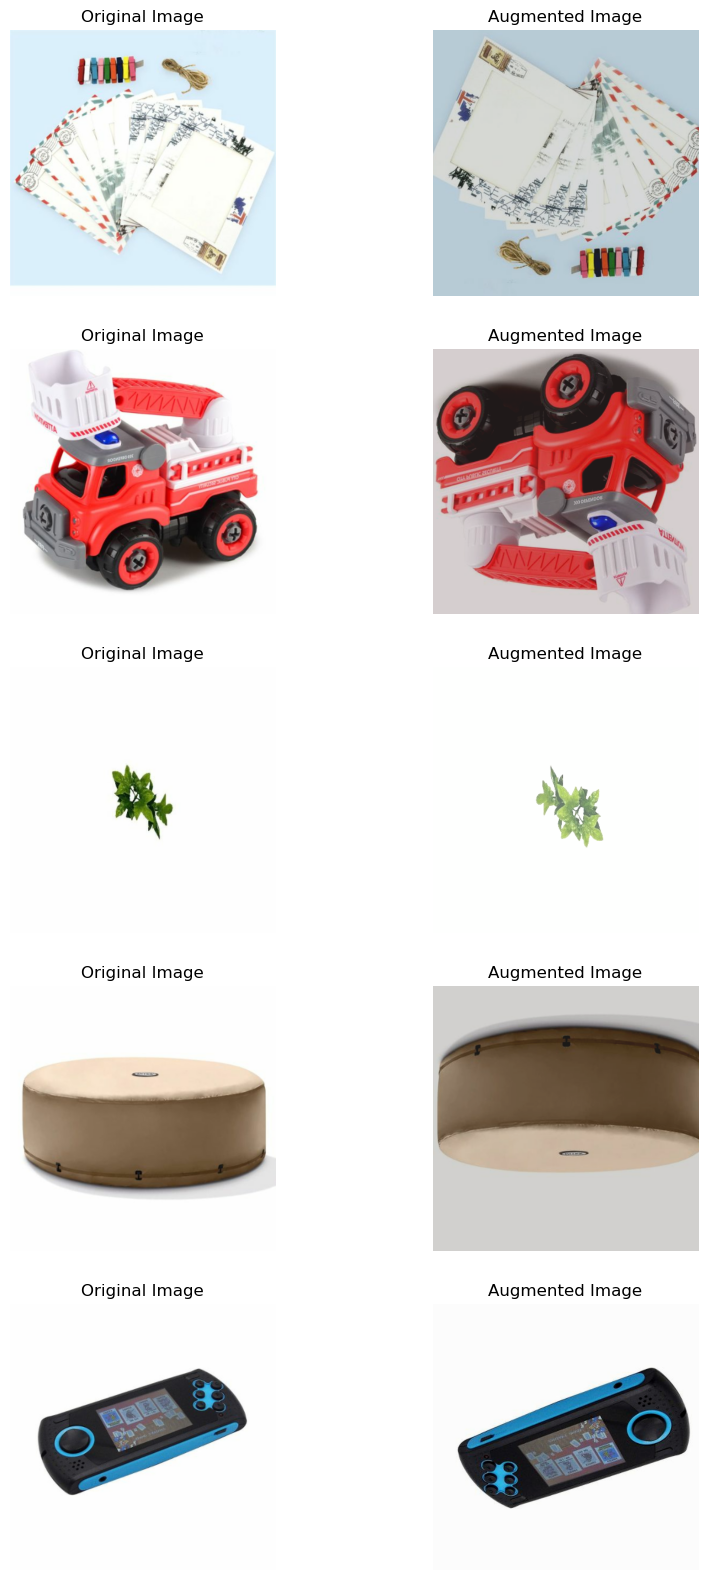

In [24]:
random_samples = X_train_path[:5]

# Créer une figure pour afficher les images
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i, nom in enumerate(random_samples):
    # Charger l'image originale
    original_image = load_image(nom)

    # Redimensionner l'image pour l'affichage
    #resized_image = tf.image.resize(original_image, (IMGSIZE, IMGSIZE))

    # Charger l'image à l'aide de la fonction load_image
    augmented_image = load_and_augment_image(nom)

    # Afficher l'image originale et l'image augmentée
    axs[i, 0].imshow(original_image)
    axs[i, 0].axis('off')
    axs[i, 0].set_title('Original Image')

    axs[i, 1].imshow(augmented_image)
    axs[i, 1].axis('off')
    axs[i, 1].set_title('Augmented Image')

plt.show()

In [25]:
from keras.applications.vgg16 import VGG16
#  help(tf.keras.applications)
# Chargement du modèle VGG16
base_model =  VGG16(include_top=False, weights='imagenet',input_shape=(IMGSIZE,IMGSIZE,3))

niv1,niv2 = 0,0
for layer in base_model.layers[:FREEZE_LAYERS]:
    niv1  +=1
    layer.trainable = False
  
# Entrainement des derniers layers de classification
for layer in base_model.layers[FREEZE_LAYERS:]:
    niv2 += 1
    layer.trainable = True
base_model.summary()
print("Nb layers gelées : ",niv1)
print("nb layers dégelées : ", niv2)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 450, 450, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 450, 450, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 450, 450, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 225, 225, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 225, 225, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 225, 225, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 112, 112, 128)     0     

# II) Activation du meilleur modèle 

In [26]:
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(27, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 14, 14, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                        

In [27]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
saveweights = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_weights.h5'
trainacc  = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_train_acc.pkl'
valacc = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_al_acc.pkl'
loss = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_loss.pkl'
valloss = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_valloss.pkl'
dfpredict = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+ '_df_predict.csv'
testoriginal = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_y_test_original2.pkl'
predoriginal = ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_test_pred_original2.pkl'

### a) lancement de l'entrainement

#### 

In [29]:
from tensorflow.keras import callbacks
NBETAPE=6
checkpoint = callbacks.ModelCheckpoint(filepath=ds.get_RACINE_SAUVEGARDE()+SUFFIXE_FICHIER+'_checkpoint.h5',
                                       monitor='val_loss',
                                       save_best_only=True,
                                       save_weights_only=False,
                                       mode='min',
                                       save_freq='epoch')


# Réduction automatique du taux d'apprentissage

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=1,
                            mode='min')



training_history = model.fit(dataset_train, epochs=40, validation_data = dataset_test, callbacks=[lr_plateau])



Epoch 1/40
2335/2335 [==============================] - 1654s 707ms/step - loss: 2.1270 - accuracy: 0.3935 - val_loss: 1.7133 - val_accuracy: 0.5094 - lr: 1.0000e-04
Epoch 2/40
2335/2335 [==============================] - 1689s 724ms/step - loss: 1.7092 - accuracy: 0.4984 - val_loss: 1.6474 - val_accuracy: 0.5216 - lr: 1.0000e-04
Epoch 3/40
2335/2335 [==============================] - 1721s 737ms/step - loss: 1.5151 - accuracy: 0.5462 - val_loss: 1.5661 - val_accuracy: 0.5463 - lr: 1.0000e-04
Epoch 4/40
2335/2335 [==============================] - 1675s 717ms/step - loss: 1.3757 - accuracy: 0.5849 - val_loss: 1.6431 - val_accuracy: 0.5412 - lr: 1.0000e-04
Epoch 5/40
2335/2335 [==============================] - 1674s 717ms/step - loss: 1.2710 - accuracy: 0.6121 - val_loss: 1.5037 - val_accuracy: 0.5695 - lr: 1.0000e-04
Epoch 6/40
2335/2335 [==============================] - 1689s 723ms/step - loss: 1.1731 - accuracy: 0.6387 - val_loss: 1.4807 - val_accuracy: 0.5765 - lr: 1.0000e-04
Epoc

In [30]:
print("Sauvegarde des poids du modèle ... ")
model.save_weights(saveweights)
#print(saveweights)
print("-"*20)

train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
tloss = training_history.history['loss']
tvalloss=training_history.history['val_loss']

print("Sauvegardes des precisions et les des pertes ... ")
with open(trainacc, 'wb') as f:
    pickle.dump(train_acc, f)
with open(valacc, 'wb') as f:
    pickle.dump(val_acc, f)
with open(loss, 'wb') as f:
    pickle.dump(tloss, f)
with open(valloss, 'wb') as f:
    pickle.dump(tvalloss, f)
#print(trainacc)
#print(valacc)
#print(loss)
#print(valloss)
print("-"*20)
    
y_test_original = np.argmax(y_test_Network, axis=1)
#print(y_test_Network[0])
y_test_original2=label_encoder.inverse_transform(y_test_original)

predictions = model.predict(dataset_test)
y_pred = np.argmax(predictions, axis=1)
test_pred_original2=label_encoder.inverse_transform(y_pred)

#print("-"*20)

top5_df = pd.DataFrame({'prdtypecode': y_test_original2,'predict': test_pred_original2})

df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')

df_pred = pd.DataFrame()
for c in Lcat:
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
    df_pred = pd.concat([df_pred, df_temp], ignore_index=True)

print("Sauvegardes des rerultats ... ")
df_pred.to_csv(dfpredict)
with open(testoriginal, 'wb') as f:
    pickle.dump(y_test_original2, f)
with open(predoriginal, 'wb') as f:
    pickle.dump(test_pred_original2, f)
#print(testoriginal)
#print(predoriginal)

Sauvegarde des poids du modèle ... 
--------------------
Sauvegardes des precisions et les des pertes ... 
--------------------
531/531 [==============================] - 266s 502ms/step
Sauvegardes des rerultats ... 


### b) affichage des precisions et des pertes par époque

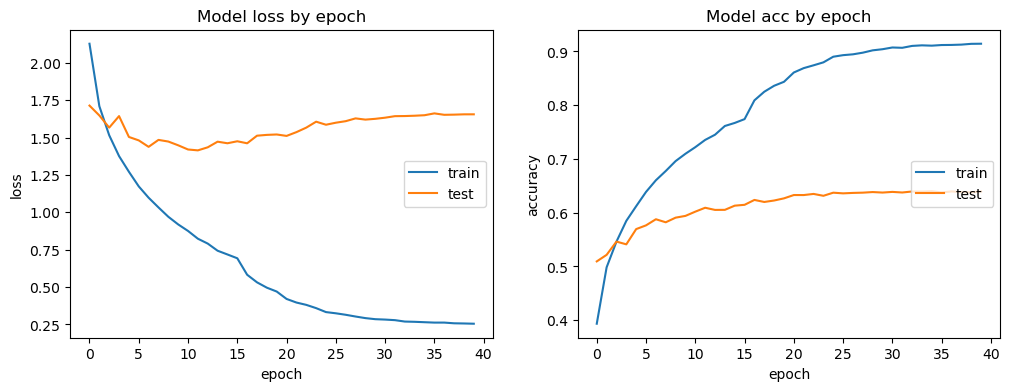

In [31]:



plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(tloss)
plt.plot(tvalloss)
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

   

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

### c) affichage des 3 meilleurs prédictions par catégorie
classé par ordre d'échantillonage obtenu après over et under sampling

In [32]:

#=========================================================================
dfp=pd.read_csv(dfpredict)
dfs=pd.read_csv(ds.get_RACINE_SAUVEGARDE()+STRATEGIE) # effectifs par classe retenu après over et under sampling
dfs.rename({'Unnamed: 0':'Categorie'},axis=1,inplace=True)
df_resume=dfs.merge(dfp,on='Categorie',how='inner')
df_resume.drop('Unnamed: 0',axis=1,inplace=True)
df_resume.head(27)

,Categorie,Qunatity,predict,pourc,predict2,pourc2,predict3,pourc3
0,2583,5000,2583,0.823702,2585,0.024976,1302,0.021548
1,1560,4058,1560,0.590148,2060,0.102463,2582,0.072906
2,1300,4036,1300,0.791873,1280,0.079286,50,0.020813
3,2060,3994,2060,0.513514,1560,0.096096,1920,0.048048
4,2522,3991,2522,0.699399,2403,0.037074,1560,0.036072
5,1280,3896,1280,0.409651,1300,0.178645,1140,0.077002
6,2403,3819,2403,0.664921,2280,0.112042,10,0.092147
7,2280,3808,2280,0.793067,2403,0.086134,10,0.059874
8,1920,3442,1920,0.789779,1560,0.068525,2060,0.045296
9,1160,3162,1160,0.927939,2403,0.015171,1281,0.013906


### d) matrice de confusion

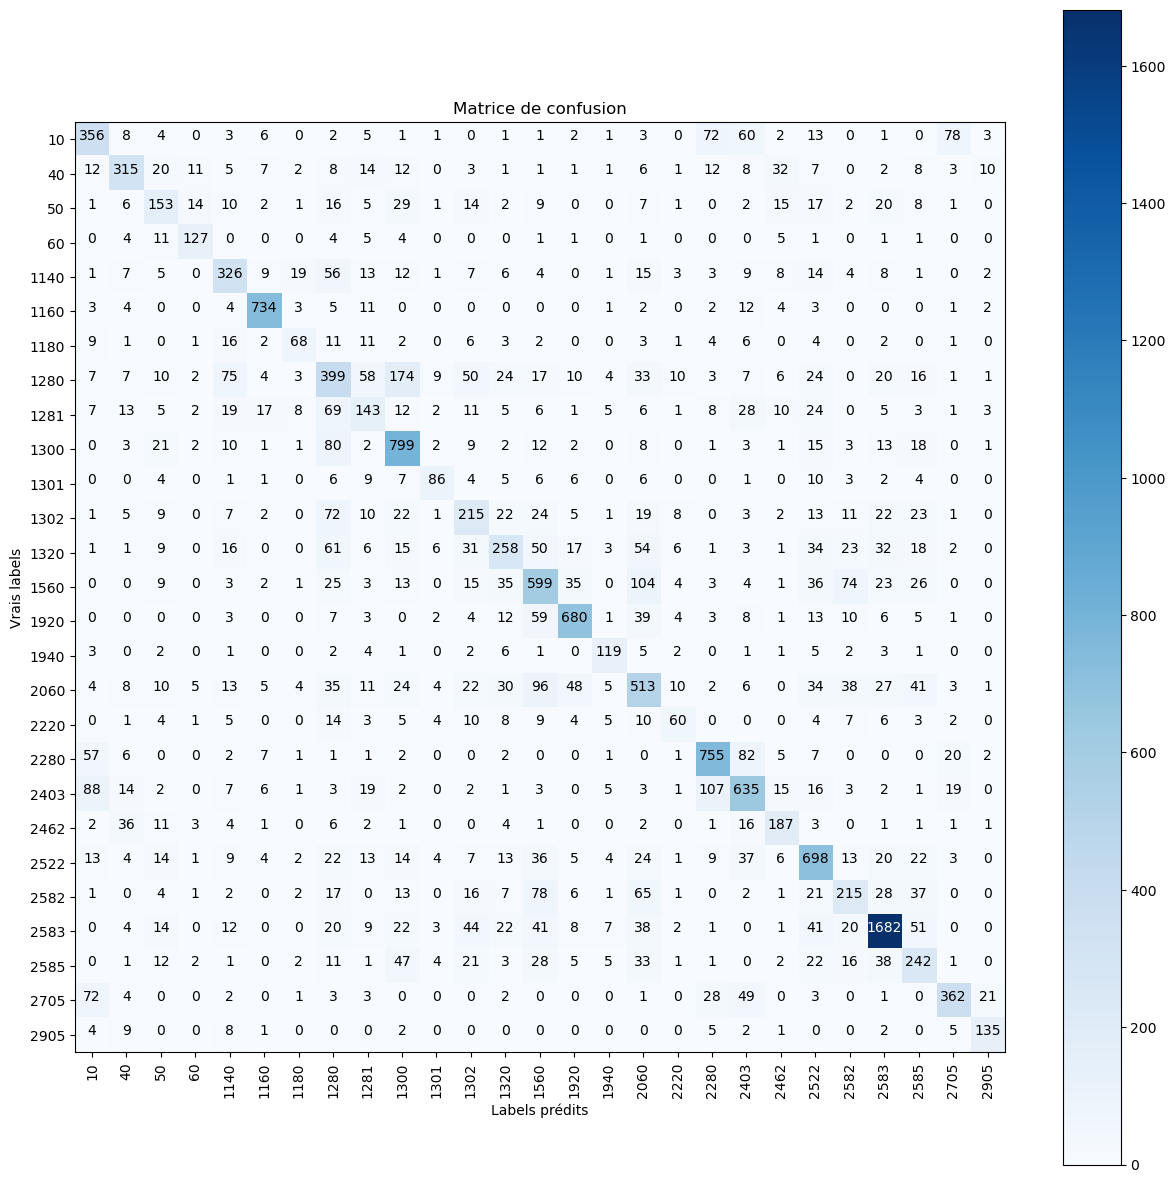

In [33]:
import itertools # Pour créer des itérateurs
#cnf_matrix = confusion_matrix(y_test, test_pred_orinal,labels=[10,2280,2403,2705,40,50,2462,1280,1281])
cnf_matrix = confusion_matrix(y_test, test_pred_original2,labels=sorted(list(set(y_test_original2))))
#print(cnf_matrix)


classes=sorted(list(set(y_test_original2)))
b=list(set(y_test_original2))

plt.figure(figsize=(15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation=90)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()


In [34]:
top5_df = pd.DataFrame({'prdtypecode': y_test_original2,'predict': test_pred_original2})
df_cross=pd.crosstab(top5_df['prdtypecode'], top5_df['predict'],normalize='index')
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1281,1300,...,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,
10,0.571429,0.012841,0.006421,0.000000,0.004815,0.009631,0.000000,0.003210,0.008026,0.001605,...,0.000000,0.115570,0.096308,0.003210,0.020867,0.000000,0.001605,0.000000,0.125201,0.004815
40,0.023904,0.627490,0.039841,0.021912,0.009960,0.013944,0.003984,0.015936,0.027888,0.023904,...,0.001992,0.023904,0.015936,0.063745,0.013944,0.000000,0.003984,0.015936,0.005976,0.019920
50,0.002976,0.017857,0.455357,0.041667,0.029762,0.005952,0.002976,0.047619,0.014881,0.086310,...,0.002976,0.000000,0.005952,0.044643,0.050595,0.005952,0.059524,0.023810,0.002976,0.000000
60,0.000000,0.024096,0.066265,0.765060,0.000000,0.000000,0.000000,0.024096,0.030120,0.024096,...,0.000000,0.000000,0.000000,0.030120,0.006024,0.000000,0.006024,0.006024,0.000000,0.000000
1140,0.001873,0.013109,0.009363,0.000000,0.610487,0.016854,0.035581,0.104869,0.024345,0.022472,...,0.005618,0.005618,0.016854,0.014981,0.026217,0.007491,0.014981,0.001873,0.000000,0.003745
1160,0.003793,0.005057,0.000000,0.000000,0.005057,0.927939,0.003793,0.006321,0.013906,0.000000,...,0.000000,0.002528,0.015171,0.005057,0.003793,0.000000,0.000000,0.000000,0.001264,0.002528
1180,0.058824,0.006536,0.000000,0.006536,0.104575,0.013072,0.444444,0.071895,0.071895,0.013072,...,0.006536,0.026144,0.039216,0.000000,0.026144,0.000000,0.013072,0.000000,0.006536,0.000000
1280,0.007187,0.007187,0.010267,0.002053,0.077002,0.004107,0.003080,0.409651,0.059548,0.178645,...,0.010267,0.003080,0.007187,0.006160,0.024641,0.000000,0.020534,0.016427,0.001027,0.001027
1281,0.016908,0.031401,0.012077,0.004831,0.045894,0.041063,0.019324,0.166667,0.345411,0.028986,...,0.002415,0.019324,0.067633,0.024155,0.057971,0.000000,0.012077,0.007246,0.002415,0.007246


### e) Rapport de classification

In [35]:
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test_original2, test_pred_original2)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test_original2, test_pred_original2)))

Précision de la prédiction: 63.94842204427697 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.55      0.57      0.56       623
          40       0.68      0.63      0.65       502
          50       0.46      0.46      0.46       336
          60       0.74      0.77      0.75       166
        1140       0.58      0.61      0.59       534
        1160       0.91      0.93      0.92       791
        1180       0.57      0.44      0.50       153
        1280       0.42      0.41      0.41       974
        1281       0.39      0.35      0.37       414
        1300       0.65      0.79      0.71      1009
        1301       0.66      0.53      0.59       161
        1302       0.44      0.43      0.43       498
        1320       0.54      0.40      0.46       648
        1560       0.55      0.59      0.57      1015
        1920       0.81      0.79      0.80       861
        1940       0.70      0.7

### f) Résumé de la classification obtenue

In [36]:
df_pred = pd.DataFrame()
for c in Lcat:
    print(c, '   ------   ', catdict[c])
    s = df_cross.loc[c].sort_values(ascending=False)[:5]
    df_temp = pd.DataFrame([{'Categorie':c,'predict':s.index[0],'pourc':s.values[0],'predict2':s.index[1],'pourc2':s.values[1],'predict3':s.index[2],'pourc3':s.values[2]}])
    df_pred = pd.concat([df_pred, df_temp], ignore_index=True)
    for index, value in s.items():  # Change ici
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")
df_pred.to_csv('dfpredict')

10    ------    livres
  : 10,  : 57.14 % , livres
  : 2705,  : 12.52 % , bds et livres
  : 2280,  : 11.56 % , magazines
  : 2403,  : 9.63 % , livres et bds
  : 2522,  : 2.09 % , produits de papeterie et rangement bureau
40    ------    jeux video pour pc et consoles
  : 40,  : 62.75 % , jeux video pour pc et consoles
  : 2462,  : 6.37 % , consoles de jeux video et jeux videos
  : 50,  : 3.98 % ,  accesoires jeux video
  : 1281,  : 2.79 % , jeux de societe/cartes
  : 10,  : 2.39 % , livres
50    ------     accesoires jeux video
  : 50,  : 45.54 % ,  accesoires jeux video
  : 1300,  : 8.63 % , Petites voitures (jouets) et maquettes
  : 2583,  : 5.95 % , accesoires de piscine
  : 2522,  : 5.06 % , produits de papeterie et rangement bureau
  : 1280,  : 4.76 % , jouets, peluches, poupees
60    ------    consoles de jeux video
  : 60,  : 76.51 % , consoles de jeux video
  : 50,  : 6.63 % ,  accesoires jeux video
  : 1281,  : 3.01 % , jeux de societe/cartes
  : 2462,  : 3.01 % , consoles de 